 # Customer Churn Analysis

In [16]:
import pandas as pd
import numpy as np

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [20]:
from sklearn.metrics import (
    roc_auc_score,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)


In [22]:
DATA_PATH = "customer_churn_data_cleaned.csv"  # <-- change if needed
df = pd.read_csv(DATA_PATH)

In [24]:
for col in ["customerID", "CustomerID", "Customer Id", "Customer ID"]:
    if col in df.columns:
        df = df.drop(columns=[col])

In [26]:
if "Churn Flag" in df.columns:
    y = df["Churn Flag"].astype(int)
elif "ChurnFlag" in df.columns:
    y = df["ChurnFlag"].astype(int)
elif "Churn" in df.columns:
    # Convert Yes/No -> 1/0
    y = df["Churn"].map({"Yes": 1, "No": 0}).astype(int)
else:
    raise ValueError("Could not find target column. Expected 'Churn Flag' or 'Churn'.")

In [28]:
drop_cols = []
for c in ["Churn Flag", "ChurnFlag", "Churn"]:
    if c in df.columns:
        drop_cols.append(c)
X = df.drop(columns=drop_cols)

In [30]:
X_encoded = pd.get_dummies(X, drop_first=True)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [34]:
model = LogisticRegression(max_iter=2000)
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

In [36]:
 #Metrics for Tableau (AUC etc.)

auc = roc_auc_score(y_test, y_prob)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

metrics_df = pd.DataFrame(
    [
        {"Metric": "AUC", "Value": auc},
        {"Metric": "Accuracy", "Value": acc},
        {"Metric": "Precision", "Value": prec},
        {"Metric": "Recall", "Value": rec},
        {"Metric": "F1", "Value": f1},
        {"Metric": "Test Set Size", "Value": len(y_test)},
        {"Metric": "Churn Rate (Test)", "Value": float(y_test.mean())},
    ]
)

metrics_df.to_csv("tableau_model_metrics.csv", index=False)

In [38]:
# Confusion matrix for Tableau 

cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

tn, fp, fn, tp = cm.ravel()

cm_df = pd.DataFrame([
    {"Actual": "No (0)",  "Predicted": "No (0)",  "Count": tn},
    {"Actual": "No (0)",  "Predicted": "Yes (1)", "Count": fp},
    {"Actual": "Yes (1)", "Predicted": "No (0)",  "Count": fn},
    {"Actual": "Yes (1)", "Predicted": "Yes (1)", "Count": tp},
])

In [40]:
total = tn + fp + fn + tp
cm_df["Percent"] = cm_df["Count"] / total

cm_df.to_csv("tableau_confusion_matrix.csv", index=False)


In [42]:
# Feature importance (coefficients)

coef = model.coef_[0]
feat_imp = pd.DataFrame({
    "Feature": X_encoded.columns,
    "Coefficient": coef
})

feat_imp["AbsCoefficient"] = feat_imp["Coefficient"].abs()
feat_imp["Direction"] = np.where(feat_imp["Coefficient"] >= 0, "Increases churn", "Decreases churn")

In [44]:
feat_imp = feat_imp.sort_values("AbsCoefficient", ascending=False)

# Keep top N for dashboard readability
TOP_N = 20
feat_imp_top = feat_imp.head(TOP_N).copy()

In [46]:
feat_imp_top.to_csv("tableau_logreg_feature_importance.csv", index=False)

print("Saved files for Tableau:")
print(" - tableau_model_metrics.csv")
print(" - tableau_confusion_matrix.csv")
print(" - tableau_logreg_feature_importance.csv")

Saved files for Tableau:
 - tableau_model_metrics.csv
 - tableau_confusion_matrix.csv
 - tableau_logreg_feature_importance.csv


### Testing RF:

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score


In [51]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1,
                       random_state=42)

In [53]:
rf_probs = rf_model.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, rf_probs)

print("Random Forest AUC:", round(rf_auc, 3))


Random Forest AUC: 0.82


In [55]:
rf_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": rf_model.feature_importances_
})

rf_importance = rf_importance.sort_values(
    by="Importance",
    ascending=False
)

rf_importance.head(10)


,Feature,Importance
3,TotalCharges,0.164174
1,tenure,0.147904
2,MonthlyCharges,0.144402
25,Contract_Two year,0.049536
10,InternetService_Fiber optic,0.044153
28,PaymentMethod_Electronic check,0.038166
32,TenureGroup_4+ years,0.032341
24,Contract_One year,0.029025
4,gender_Male,0.025597
26,PaperlessBilling_Yes,0.024506


In [59]:
print("Top LR predictors:")
print(feat_imp.head(5)[["Feature", "Coefficient"]])

print("\nTop RF predictors:")
print(rf_importance.head(5))


Top LR predictors:
                        Feature  Coefficient
1                        tenure    -1.238663
10  InternetService_Fiber optic     0.703264
2                MonthlyCharges    -0.699359
25            Contract_Two year    -0.656167
24            Contract_One year    -0.329253

Top RF predictors:
                        Feature  Importance
3                  TotalCharges    0.164174
1                        tenure    0.147904
2                MonthlyCharges    0.144402
25            Contract_Two year    0.049536
10  InternetService_Fiber optic    0.044153


In [70]:
# Get feature sets
lr_features = set(lr_top["Feature"])
rf_features = set(rf_top["Feature"])

# Intersection
shared_features = lr_features.intersection(rf_features)

shared_features


{'Contract_Two year',
 'InternetService_Fiber optic',
 'MonthlyCharges',
 'tenure'}

In [76]:
agreement_matrix_norm = agreement_matrix.copy()

agreement_matrix_norm["Logistic Regression"] = (
    agreement_matrix_norm["Logistic Regression"]
    / agreement_matrix_norm["Logistic Regression"].max()
)

agreement_matrix_norm["Random Forest"] = (
    agreement_matrix_norm["Random Forest"]
    / agreement_matrix_norm["Random Forest"].max()
)


In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

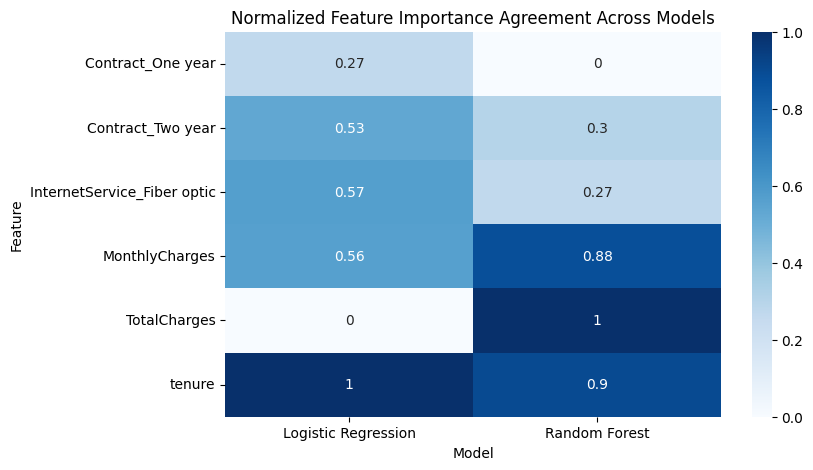

In [80]:
#plot heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(
    agreement_matrix_norm,
    annot=True,
    cmap="Blues",
    vmin=0,
    vmax=1
)
plt.title("Normalized Feature Importance Agreement Across Models")
plt.show()


After normalization, it becomes obvious that: tenure is top-ranked in both models, MonthlyCharges appears consistently important, Contract length matters across approaches, InternetService_Fiber optic is a recurring churn risk